### Import required packages

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import unicodedata
import networkx as nx
import os
import re
from pyvis.network import Network
import community.community_louvain as cl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
#Establish working directory
work_dir = 'c:/users/myxna/desktop/datascienceprojects/lotr'

In [3]:
#Download the spacy small english language model
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 653.6 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 2.3 MB/s eta 0:00:06
     - -------------------------------------- 0.4/12.8 MB 2.8 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 3.3 MB/s eta 0:00:04
     -- ------------------------------------- 0.8/12.8 MB 3.6 MB/s eta 0:00:04
     -- ------------------------------------- 1.0/12.8 MB 3.6 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/12.8 MB 3.7 MB/s eta 0:00:04
     ---- ----------------------------------- 1.3/12.8 MB 3.7 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 3.8 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 3.9 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/12.8 MB 3.8 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 

In [4]:
#Load spacy's english language model
NER = spacy.load('en_core_web_sm')

### Extract text from books

In [5]:
#Load Tolkien's book file names in list
books = [b for b in os.scandir(work_dir + '/data') if '.txt' in b.name]

In [6]:
#View contents of book name list
books

[<DirEntry 'The_Hobbit.txt'>,
 <DirEntry 'The_Lord_of_the_Rings.txt'>,
 <DirEntry 'The_Silmarillion.txt'>]

In [7]:
#Open and read books to variable
book = books[1]
with open(book, 'r', encoding='ansi', errors='ignore') as file:
    book_text = file.read()

#Increase the max_length limit of spacy's NER model
NER.max_length = 3000000  #or any value greater than the length of your text

#Process the text with model
book_doc = NER(book_text)

In [8]:
#Display entities in the first 2500 tokens of the text
displacy.render(book_doc[0:2500], style = 'ent')

In [9]:
#Load character data from pickle file to pandas df
character_df = pd.read_pickle(work_dir + '/data/characters.pkl')

In [10]:
#Show first 50 entries of character_df
character_df.head(50)

,book,character
0,Category:The Hobbit characters,Bilbo Baggins
1,Category:The Hobbit characters,Balin
2,Category:The Hobbit characters,Bard
3,Category:The Hobbit characters,Beorn
4,Category:The Hobbit characters,Bifur
5,Category:The Hobbit characters,Bladorthin
6,Category:The Hobbit characters,Bofur
7,Category:The Hobbit characters,Bolg
8,Category:The Hobbit characters,Bombur
9,Category:The Hobbit characters,Captain of the guard


### Clean and tidy character names for NER

In [11]:
#Function to split rows with multiple characters in the same row
def split_rows(df):
    new_rows = []
    for index, row in df.iterrows():
        names = row['character'].replace(' and ', ',').split(',')
        for name in names:
            new_row = row.copy()
            new_row['character'] = name.strip()
            new_rows.append(new_row)
    return pd.DataFrame(new_rows)

In [12]:
#Separate rows with multiple names in character_df
character_df = split_rows(character_df)

#Display the new character_df's 50 first rows
character_df.head(50)

,book,character
0,Category:The Hobbit characters,Bilbo Baggins
1,Category:The Hobbit characters,Balin
2,Category:The Hobbit characters,Bard
3,Category:The Hobbit characters,Beorn
4,Category:The Hobbit characters,Bifur
5,Category:The Hobbit characters,Bladorthin
6,Category:The Hobbit characters,Bofur
7,Category:The Hobbit characters,Bolg
8,Category:The Hobbit characters,Bombur
9,Category:The Hobbit characters,Captain of the guard


In [13]:
#Remove special characters from character names
character_df['character'] = character_df['character'].apply(lambda x: re.sub('[\(}.*?{\)]', '', x))

In [14]:
#Remove Character entries that do not contain valid characters or characters that are not named in the book,
#for example: row 9, "Captain of the guard"
remove_character_list = ['Captain of the guard', 'Category:Characters that have appeared in the Hobbit', 'the Lord of the Rings', 'Master of Lake-town', 'Great Goblin', 'Great grey chief wolf', 'Chief of the guards Woodland Realm', 'Councilors Lake-town', '', 'Category:Major characters The Lord of the Rings', 'Category:Minor characters The Lord of the Rings', 'Witch-king\'s winged steed', ]

# Filter the DataFrame to keep only rows where 'character' does not contain strings from remove_character_list
character_df = character_df[~character_df['character'].isin(remove_character_list)]

#See changes in character_df
character_df.head(50)

,book,character
0,Category:The Hobbit characters,Bilbo Baggins
1,Category:The Hobbit characters,Balin
2,Category:The Hobbit characters,Bard
3,Category:The Hobbit characters,Beorn
4,Category:The Hobbit characters,Bifur
5,Category:The Hobbit characters,Bladorthin
6,Category:The Hobbit characters,Bofur
7,Category:The Hobbit characters,Bolg
8,Category:The Hobbit characters,Bombur
10,Category:The Hobbit characters,Carc


In [15]:
#This function removes special encoded characters from the book characters' names
def replace_accented_characters(row):
    if row['book'] in ['Category:The Hobbit characters', 'Category:The Silmarillion characters']:
        character_list = list(row['character'])
        for i, char in enumerate(character_list):
            if unicodedata.category(char)[0] == 'L':
                # Replace special characters with their non-accented equivalents
                character_list[i] = unicodedata.normalize('NFKD', char).encode('ascii', 'ignore').decode('utf-8')
        return ''.join(character_list)
    else:
        return row['character']

In [16]:
# Apply the function to create a new column 'modified_character'
character_df['character_modified'] = character_df.apply(replace_accented_characters, axis=1)
character_df

,book,character,character_modified
0,Category:The Hobbit characters,Bilbo Baggins,Bilbo Baggins
1,Category:The Hobbit characters,Balin,Balin
2,Category:The Hobbit characters,Bard,Bard
3,Category:The Hobbit characters,Beorn,Beorn
4,Category:The Hobbit characters,Bifur,Bifur
...,...,...,...
283,Category:The Silmarillion characters,Túrin,Turin
284,Category:The Silmarillion characters,Uinen,Uinen
285,Category:The Silmarillion characters,Uldor,Uldor
286,Category:The Silmarillion characters,Ulfang,Ulfang


In [17]:
#Create a column in the character_df containing the character's first name
character_df['character_firstname'] = character_df['character_modified'].apply(lambda x: x.split(' ', 1)[0])

In [18]:
#Look through the dataframe for quality
pd.set_option('display.max_rows', None)
character_df

,book,character,character_modified,character_firstname
0,Category:The Hobbit characters,Bilbo Baggins,Bilbo Baggins,Bilbo
1,Category:The Hobbit characters,Balin,Balin,Balin
2,Category:The Hobbit characters,Bard,Bard,Bard
3,Category:The Hobbit characters,Beorn,Beorn,Beorn
4,Category:The Hobbit characters,Bifur,Bifur,Bifur
5,Category:The Hobbit characters,Bladorthin,Bladorthin,Bladorthin
6,Category:The Hobbit characters,Bofur,Bofur,Bofur
7,Category:The Hobbit characters,Bolg,Bolg,Bolg
8,Category:The Hobbit characters,Bombur,Bombur,Bombur
10,Category:The Hobbit characters,Carc,Carc,Carc


In [19]:
#Define a dictionary to map first names to nicknames
nickname_mapping = {
    'Morgoth': 'Melkor',
    'Samwise': 'Sam',
    'Meriadoc': 'Merry',
    'Perigrin': 'Pippin',
    'Gandalf': 'Mithrandir',
    'Gollum': 'Sméagol',
    'Aragorn': 'Strider',
    'Sauron': 'Dark Lord'
}

#Create an empty list to store nicknames
nicknames = []

#Iterate over the 'character_firstname' column
for first_name in character_df['character_firstname']:
    #Check if the first name is in the nickname mapping dictionary
    if first_name in nickname_mapping:
        #If it is, append the corresponding nickname
        nicknames.append(nickname_mapping[first_name])
    else:
        #If not, append an empty string
        nicknames.append('')

#Add the list of nicknames as a new column to the DataFrame
character_df['character_nickname'] = nicknames

In [20]:
#Show first 50 entries of character_df
character_df.head(50)

,book,character,character_modified,character_firstname,character_nickname
0,Category:The Hobbit characters,Bilbo Baggins,Bilbo Baggins,Bilbo,
1,Category:The Hobbit characters,Balin,Balin,Balin,
2,Category:The Hobbit characters,Bard,Bard,Bard,
3,Category:The Hobbit characters,Beorn,Beorn,Beorn,
4,Category:The Hobbit characters,Bifur,Bifur,Bifur,
5,Category:The Hobbit characters,Bladorthin,Bladorthin,Bladorthin,
6,Category:The Hobbit characters,Bofur,Bofur,Bofur,
7,Category:The Hobbit characters,Bolg,Bolg,Bolg,
8,Category:The Hobbit characters,Bombur,Bombur,Bombur,
10,Category:The Hobbit characters,Carc,Carc,Carc,


### Extract, clean, and tidy entities from book text

In [21]:
#Create a list to be used to hold sentences and entities contained within respective sentences
sent_entity_df= []

#Loop over sentences in books
for sent in book_doc.sents:
    #Store entities from individual sentence in list
    entity_list = [ent.text for ent in sent.ents]
    #Add sentence and entities to dataframe
    sent_entity_df.append({'sentence': sent, 'entities': entity_list})
    
#Convert list of dictionaries to dataframe    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [22]:
#Look at the first 100 sentences saved and their respective entities
sent_entity_df.head(100)

,sentence,entities
0,"(Three, Rings, for, the, Elven, -, kings, unde...","[Three, Elven, Seven, Dwarf, Nine, Mortal Men,..."
1,"(One, Ring, to, rule, them, all, ,, One, Ring,...","[One, One, Shadows]"
2,"(FOREWORD, \n\n, This, tale, grew, in, the, te...","[FOREWORD, the Great War of the Ring]"
3,"(It, was, begun, soon, after, _)",[]
4,"(The, Hobbit, _, was, written, and, before, it...","[The Hobbit, 1937, first, the Elder Days, some..."
5,"(I, desired, to, do, this, for, my, own, satis...",[Elvish]
6,"(When, those, whose, advice, and, opinion, I, ...",[]
7,"(no, hope, ,, _)",[]
8,"(I, went, back, to, the, sequel, ,, encouraged...",[]
9,"(But, the, story, was, drawn, irresistibly, to...",[]


In [23]:
#Function to filter the sentence-entity dataframe for sentences that only contain 
#character full names, first names, or nicknames
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character_modified)
            or ent in list(character_df.character_firstname)
            or ent in list(character_df.character_nickname)
           ]

In [24]:
#Create a new column for the sentence-entity dataframe that captures only the 
#specified character names from the entitiy list
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

In [25]:
#Create a new DataFrame that contains only sentences where at least one recognized entity is a
#specified character
sent_entity_filtered_df = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]

#Look at the first 10 instances of the new, filtered sentence-entity DataFrame
sent_entity_filtered_df.head(50)

,sentence,entities,character_entities
11,"(The, Hobbit, ,, _, in, which, there, were, al...","[The Hobbit, Gondolin, Durin]",[Durin]
16,"(In, spite, of, the, darkness, of, the, next, ...","[the next five years, night, Balin, Moria]",[Balin]
42,"(If, it, had, inspired, or, directed, the, dev...","[Sauron, Barad-dûr]",[Sauron]
55,"(It, is, an, essential, part, of, the, plot, ,...",[Saruman],[Saruman]
71,"(That, story, was, derived, from, the, earlier...","[the Red Book, Bilbo, Hobbit]",[Bilbo]
99,"(But, in, the, days, of, Bilbo, ,, and, of, Fr...","[the days, Bilbo]",[Bilbo]
101,"(Of, their, original, home, the, Hobbits, in, ...",[Bilbo],[Bilbo]
122,"(Even, in, Bilbo, 's, time, the, strong, Fallo...",[Bilbo],[Bilbo]
126,"(Most, of, their, earlier, settlements, had, l...","[Bilbo, one, first, Bree, Chetwood, some forty...",[Bilbo]
147,"(In, olden, days, they, had, ,, of, course, ,,...","[olden days, Bilbo]",[Bilbo]


In [26]:
#Split rows of the sentence-entity DataFrame where multiple characters are
#present in the same sentence
sent_entity_filtered_df.loc[:, 'character_entities'] = sent_entity_filtered_df['character_entities'].apply(lambda x: [item.split()[0] for
                                                                                                                      item in x])

In [27]:
#Display the sentence-entity DataFrame
pd.reset_option('^display.', silent=True)
sent_entity_filtered_df.head(50)

,sentence,entities,character_entities
11,"(The, Hobbit, ,, _, in, which, there, were, al...","[The Hobbit, Gondolin, Durin]",[Durin]
16,"(In, spite, of, the, darkness, of, the, next, ...","[the next five years, night, Balin, Moria]",[Balin]
42,"(If, it, had, inspired, or, directed, the, dev...","[Sauron, Barad-dûr]",[Sauron]
55,"(It, is, an, essential, part, of, the, plot, ,...",[Saruman],[Saruman]
71,"(That, story, was, derived, from, the, earlier...","[the Red Book, Bilbo, Hobbit]",[Bilbo]
99,"(But, in, the, days, of, Bilbo, ,, and, of, Fr...","[the days, Bilbo]",[Bilbo]
101,"(Of, their, original, home, the, Hobbits, in, ...",[Bilbo],[Bilbo]
122,"(Even, in, Bilbo, 's, time, the, strong, Fallo...",[Bilbo],[Bilbo]
126,"(Most, of, their, earlier, settlements, had, l...","[Bilbo, one, first, Bree, Chetwood, some forty...",[Bilbo]
147,"(In, olden, days, they, had, ,, of, course, ,,...","[olden days, Bilbo]",[Bilbo]


### Extract and clean relationships between characters from text using NER

In [28]:
#Set window size to define what a relationship is
window_size = 5
#Create a list to house relationships between characters that will become a DataFrame
relationships = []

#Loop through the sentence-entity DataFrame
for i in range(sent_entity_filtered_df.index[-1]):
    #Set end of window, ensure the window does not exceed dataframe index
    end_i = min(i + window_size, sent_entity_filtered_df.index[-1])
    #Create list of characters that fall in the window size
    char_list = sum((sent_entity_filtered_df.loc[i: end_i].character_entities), [])
    
    #Create a new list of only unique characters from char_list
    char_unique = [char_list[i] for i in range(len(char_list))
                  if (i == 0) or char_list[i] != char_list[i-1]]
    #Loop through char_unique to add unique relationships to relationship dataframe.
    #Ensures character does not have a relationship with themselves
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({'source': a, 'target': b})

In [29]:
#Store list of dictionaries as DataFrame
relationship_df = pd.DataFrame(relationships)

In [30]:
#Show first 150 relationships in relationship DataFrame
relationship_df.head(150)

,source,target
0,Durin,Balin
1,Bilbo,Bandobras
2,Bilbo,Bandobras
3,Bilbo,Bandobras
4,Bilbo,Bandobras
...,...,...
145,Elendil,Sauron
146,Sauron,Meriadoc
147,Sauron,Meriadoc
148,Meriadoc,Elrond


In [31]:
#Alphabetically sort the relationships 
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Balin,Durin
1,Bandobras,Bilbo
2,Bandobras,Bilbo
3,Bandobras,Bilbo
4,Bandobras,Bilbo
...,...,...
19508,Merry,Sam
19509,Merry,Sam
19510,Merry,Sam
19511,Merry,Sam


In [32]:
#Create a new column called 'value' to count each relationship as 1 instance.
relationship_df['value'] = 1
#Group duplicate relationships and sum the values to quantify the strength of the relationship
relationship_df = relationship_df.groupby(['source', 'target'], sort = False, as_index = False).sum()

In [33]:
#Invert the nickname mapping dictionary
inverse_mapping = {v: k for k, v in nickname_mapping.items()}

#Replace values in 'source' and 'target' columns with dictionary keys
relationship_df['source'] = relationship_df['source'].map(inverse_mapping).fillna(relationship_df['source'])
relationship_df['target'] = relationship_df['target'].map(inverse_mapping).fillna(relationship_df['target'])

In [34]:
def remove_self_relationships(relationship_df):
    for index, row in relationship_df.iterrows():
        if row['source'] == row['target']:
            relationship_df.drop(index, inplace=True)
    return relationship_df

In [35]:
# Apply the function to remove rows where nickname and firstname are self relating
relationship_filtered_df = remove_self_relationships(relationship_df)

In [36]:
#Look at the first 10 rows of relationship Dataframe
relationship_filtered_df.head(50)

,source,target,value
0,Balin,Durin,9
1,Bandobras,Bilbo,5
2,Bilbo,Frodo,688
3,Bilbo,Thorin,23
4,Bilbo,Gollum,168
5,Gandalf,Gollum,34
6,Bilbo,Gandalf,272
7,Bilbo,Peregrin,2
8,Barahir,Frodo,3
9,Frodo,Meriadoc,3


### Visualize the network

In [37]:
#Build the network
G = nx.from_pandas_edgelist(relationship_filtered_df,
                           source = 'source',
                           target = 'target',
                           edge_attr = 'value',
                           create_using = nx.Graph())

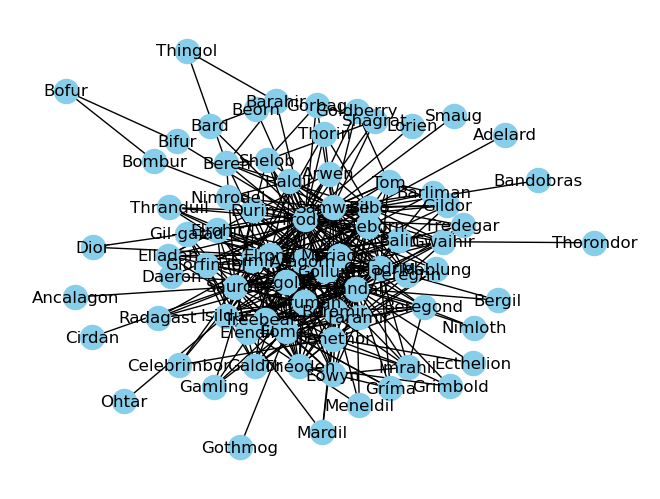

In [38]:
#Set visualization parameters for basic network
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels = True, node_color = 'skyblue', edge_cmap = plt.cm.Blues, pos = pos)
#Save figure
plt.savefig(work_dir + '/assets/img/LOTR_basic_net.png')
#Show figure
plt.show()

In [39]:
#Show each character's number of degrees
dict(G.degree)

{'Balin': 9,
 'Durin': 8,
 'Bandobras': 1,
 'Bilbo': 23,
 'Frodo': 48,
 'Thorin': 4,
 'Gollum': 20,
 'Gandalf': 43,
 'Peregrin': 12,
 'Barahir': 3,
 'Meriadoc': 31,
 'Elendil': 12,
 'Sauron': 29,
 'Elrond': 35,
 'Celeborn': 14,
 'Galadriel': 18,
 'Samwise': 33,
 'Adelard': 1,
 'Fredegar': 5,
 'Saruman': 25,
 'Gil-galad': 9,
 'Isildur': 19,
 'Ancalagon': 1,
 'Gildor': 6,
 'Tom': 9,
 'Goldberry': 3,
 'Barliman': 5,
 'Aragorn': 34,
 'Beren': 8,
 'Thingol': 2,
 'Glorfindel': 8,
 'Arwen': 5,
 'Elladan': 7,
 'Elrohir': 9,
 'Beorn': 2,
 'Bard': 2,
 'Bifur': 2,
 'Bofur': 2,
 'Bombur': 2,
 'Gimli': 24,
 'Galdor': 9,
 'Legolas': 29,
 'Thranduil': 5,
 'Boromir': 26,
 'Celebrimbor': 3,
 'Dior': 2,
 'Ohtar': 1,
 'Meneldil': 3,
 'Denethor': 21,
 'Radagast': 4,
 'Gwaihir': 8,
 'Cirdan': 1,
 'Daeron': 2,
 'Nimrodel': 6,
 'Haldir': 10,
 'Éomer': 24,
 'Théoden': 16,
 'Treebeard': 12,
 'Gríma': 5,
 'Éowyn': 10,
 'Gamling': 4,
 'Grimbold': 3,
 'Faramir': 19,
 'Mablung': 6,
 'Mardil': 3,
 'Shelob': 8,
 'Lo

In [40]:
#Function to update node labels
def update_node_labels(graph, character_dataframe):
    #Loop through nodes in graph
    for node in graph.nodes:
        first_name = node
        full_name = character_dataframe.loc[character_dataframe['character_firstname'] == 
                                            first_name, 'character'].iloc[0]
        graph.nodes[node]['label'] = full_name

In [41]:
def build_adv_network(graph, character_df):

    #Set paramaters for advanced network visualiztion
    net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')

    #Store the degree for each node in a dictionary 
    node_degree = dict(graph.degree)

    #Set size of nodes based on the node_degree
    nx.set_node_attributes(graph, node_degree, 'size')

    #Update node labels
    update_node_labels(graph, character_df)

    #Rebuild network
    net.from_nx(graph)

    #Set additional options for the network
    net.set_options('''
    var options = {
    "physics": {
    "maxVelocity": 5
    }
    }
    ''')
    return net

In [42]:
#Build advanced network
adv_net = build_adv_network(G, character_df)

#Save figure
adv_net.write_html(work_dir + '/assets/img/LOTR_adv_net.html')

#Display advanced network
adv_net.show('LOTR_adv_net.html')

LOTR_adv_net.html


In [43]:
#Use the louvain community algorithm to determine the optimal community partitions
communities = cl.best_partition(G)

In [44]:
#Display character's communities
communities

{'Balin': 2,
 'Durin': 2,
 'Bandobras': 0,
 'Bilbo': 0,
 'Frodo': 3,
 'Thorin': 3,
 'Gollum': 1,
 'Gandalf': 1,
 'Peregrin': 0,
 'Barahir': 3,
 'Meriadoc': 0,
 'Elendil': 1,
 'Sauron': 1,
 'Elrond': 0,
 'Celeborn': 2,
 'Galadriel': 2,
 'Samwise': 3,
 'Adelard': 0,
 'Fredegar': 0,
 'Saruman': 2,
 'Gil-galad': 0,
 'Isildur': 1,
 'Ancalagon': 1,
 'Gildor': 3,
 'Tom': 3,
 'Goldberry': 3,
 'Barliman': 3,
 'Aragorn': 2,
 'Beren': 3,
 'Thingol': 3,
 'Glorfindel': 1,
 'Arwen': 0,
 'Elladan': 0,
 'Elrohir': 0,
 'Beorn': 3,
 'Bard': 3,
 'Bifur': 3,
 'Bofur': 3,
 'Bombur': 3,
 'Gimli': 2,
 'Galdor': 1,
 'Legolas': 2,
 'Thranduil': 2,
 'Boromir': 1,
 'Celebrimbor': 1,
 'Dior': 0,
 'Ohtar': 1,
 'Meneldil': 1,
 'Denethor': 1,
 'Radagast': 0,
 'Gwaihir': 3,
 'Cirdan': 1,
 'Daeron': 1,
 'Nimrodel': 2,
 'Haldir': 2,
 'Éomer': 2,
 'Théoden': 2,
 'Treebeard': 2,
 'Gríma': 2,
 'Éowyn': 2,
 'Gamling': 2,
 'Grimbold': 1,
 'Faramir': 1,
 'Mablung': 1,
 'Mardil': 1,
 'Shelob': 3,
 'Lorien': 3,
 'Shagrat': 3,


In [45]:
def build_adv_comm_net(G, communities):
    nx.set_node_attributes(G, communities, 'group')
    
    comm_net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white')
    comm_net.set_options('''
    var options = {
    "physics": {
    "maxVelocity": 5
    }
    }
    ''')

    #Update node labels
    update_node_labels(G, character_df)
    
    comm_net.from_nx(G)
    
    return comm_net

In [46]:
#Build advanced network with nodes that have a community designation
adv_comm_net = build_adv_comm_net(G, communities)

#Save figure
adv_comm_net.write_html(work_dir + '/assets/img/LOTR_adv_comm_net.html')

#Display communities in the advanced network
adv_comm_net.show('LOTR_adv_comm_net.html')



LOTR_adv_comm_net.html


### Character Importance/Insights

In [47]:
def visualize_character_insights(node_df, insight):
    # Set seaborn style
    sns.set_style("whitegrid")
    
    # Get top 10 nodes by centrality
    top_10_nodes = node_df.sort_values('centrality', ascending=False).head(10)
    
    # Plot top 10 nodes using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_10_nodes.index, y='centrality', data=top_10_nodes, palette='viridis')
    
    # Add labels and title
    plt.title('Top 10 Characters by ' + insight.title() + ' Centrality')
    plt.xlabel('Characters')
    plt.ylabel(insight.title() + " Centrality")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(work_dir + '/assets/img/LOTR_' + insight + '.png')
    plt.show()

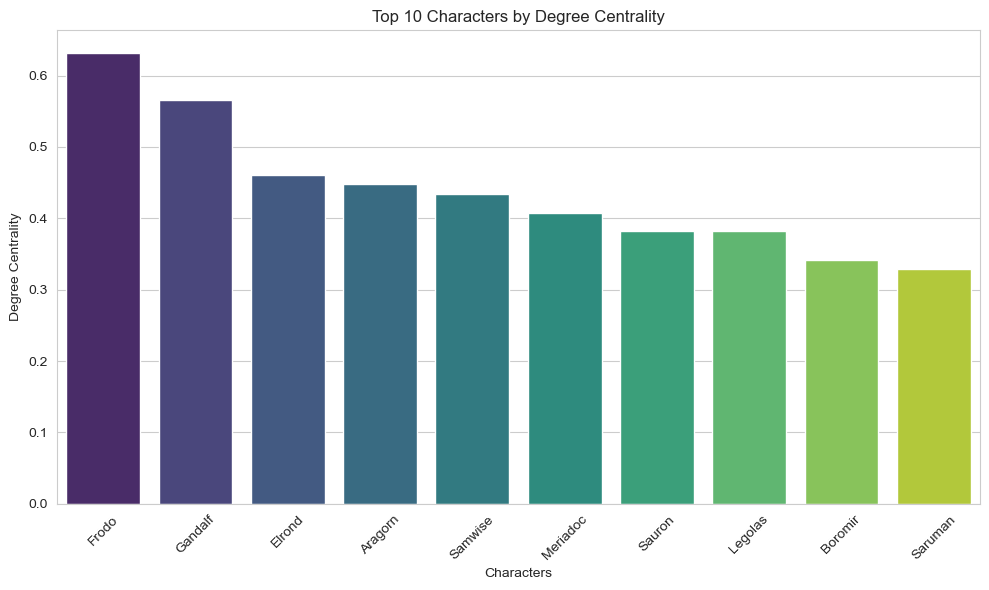

In [48]:
#Degree centrality
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
visualize_character_insights(degree_df, 'degree')

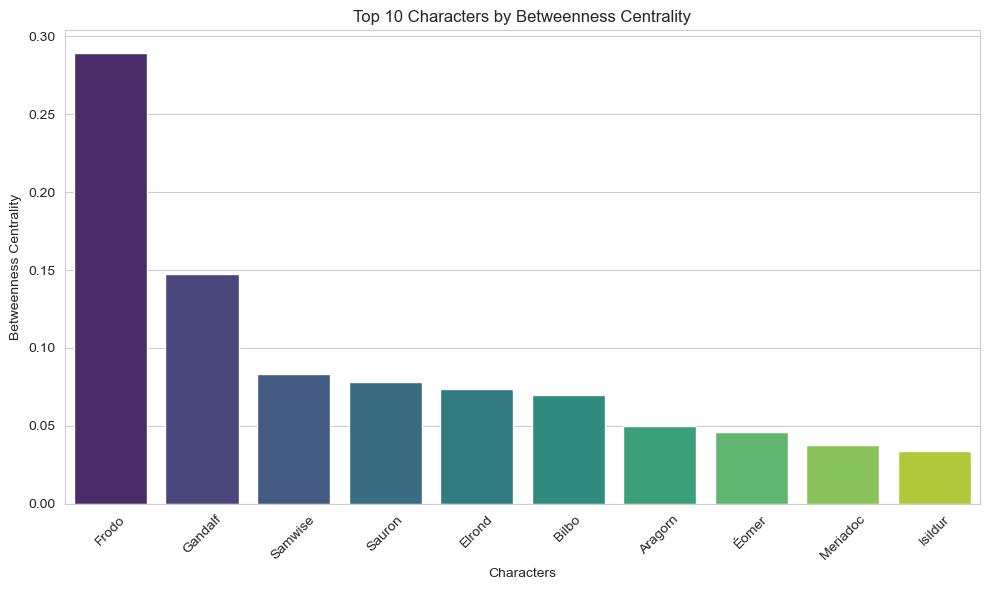

In [49]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
visualize_character_insights(betweenness_df, 'betweenness')

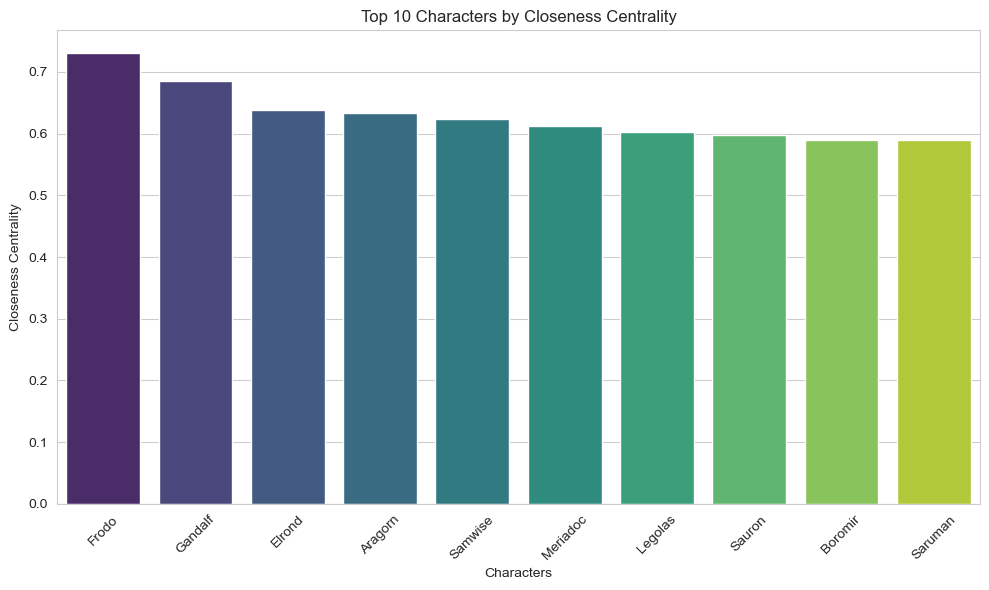

In [50]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
visualize_character_insights(closeness_df, 'closeness')

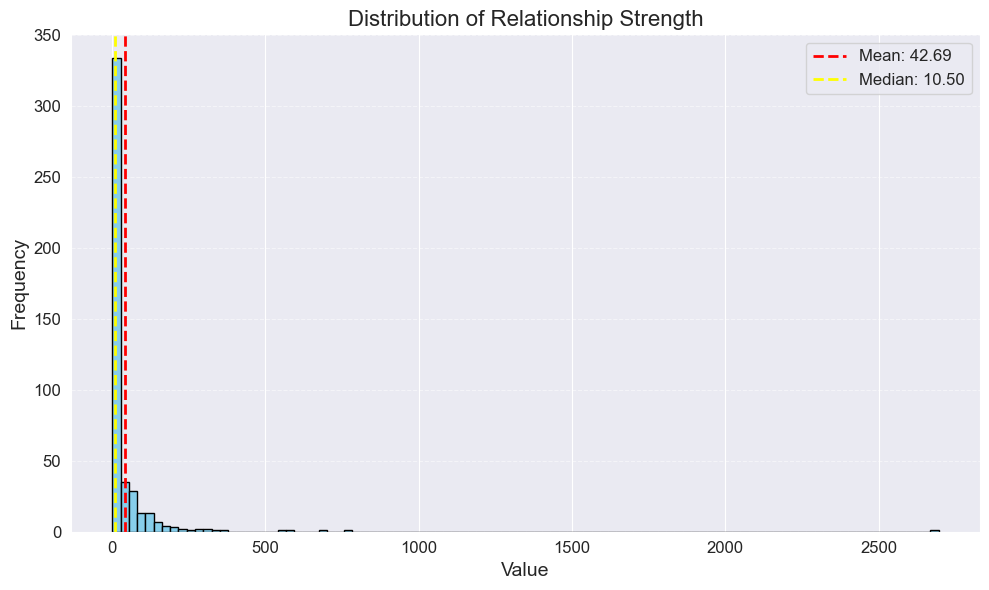

In [51]:
# Set the style of the plot using seaborn
sns.set_style('darkgrid')

# Plot histogram of the distribution of values
plt.figure(figsize=(10, 6))
plt.hist(relationship_filtered_df['value'], bins=100, color='skyblue', edgecolor='black')

plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Relationship Strength', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add a vertical line for the mean value
mean_value = relationship_filtered_df['value'].mean()
median_value = relationship_filtered_df['value'].median()
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='yellow', linestyle='--', linewidth=2, label=f'Median: {median_value:.2f}')
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig(work_dir + '/assets/img/LOTR_Relationship_Strength.png')
plt.show()

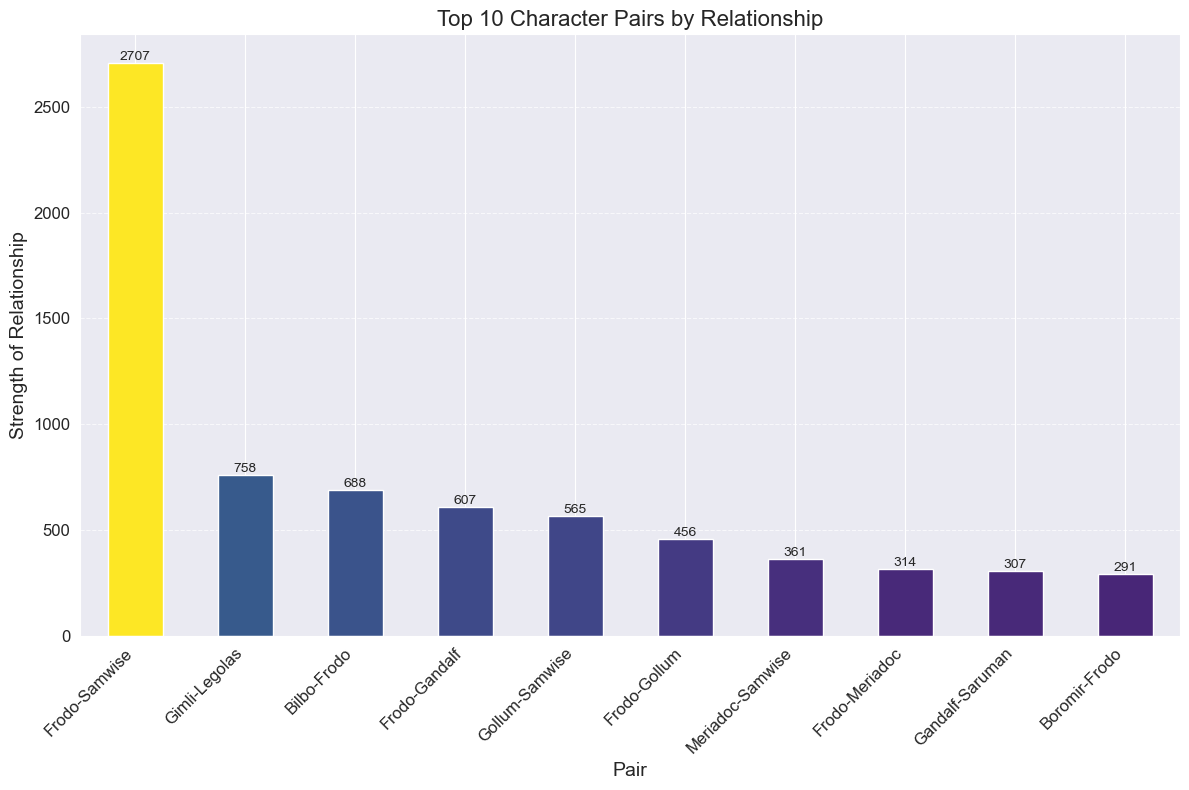

In [52]:
# Create a new column 'pair' by combining 'source' and 'target' columns
relationship_filtered_df['pair'] = relationship_filtered_df['source'] + '-' + relationship_filtered_df['target']

# Group by 'pair' and calculate the sum of values
pair_sum = relationship_filtered_df.groupby('pair')['value'].sum()

# Sort the pairs by the sum of values and select the top 10
top_10_pairs = pair_sum.sort_values(ascending=False).head(10)

# Define a custom color palette using the Viridis colormap
colors = cm.viridis(top_10_pairs / top_10_pairs.max())

# Plot the top 10 pairs with improved aesthetics
plt.figure(figsize=(12, 8))
top_10_pairs.plot(kind='bar', color=colors)

plt.xlabel('Pair', fontsize=14)
plt.ylabel('Strength of Relationship', fontsize=14)
plt.title('Top 10 Character Pairs by Relationship', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add annotations with values on top of bars
for i, v in enumerate(top_10_pairs):
    plt.text(i, v + 0.5, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(work_dir + '/assets/img/LOTR_Top_10_Relationship_Pairs.png')
plt.show()